In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.colors import ListedColormap
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.metrics import DistanceMetric, silhouette_score
from sklearn.cluster import KMeans
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

from preprocess import read_users_file


# Load data

In [27]:
images_folder = '../../images/' 
cmap = 'Set3'
idx = metrics.sort_values(by='performance').index
colors = ['#8da0cb', '#e78ac3','#a6d854', '#ffd92f']
cmap_ = ListedColormap(colors)

In [3]:
users_and_metrics = pd.read_pickle('../data/users_and_metrics.pkl')

In [4]:
users_calc = users_and_metrics['2019-2022']
metrics = users_calc.iloc[:, -5:]

# Descriptive statistics

In [5]:
describe = metrics.describe()
describe.loc['skew'] = metrics.skew()
describe.loc['kurt'] = metrics.kurtosis()
describe.T

,count,mean,std,min,25%,50%,75%,max,skew,kurt
productivity,45.0,0.526545,0.185774,0.115878,0.372335,0.548110,0.666406,0.945870,-0.072580,-0.374524
adaptability,45.0,0.494694,0.179488,0.082365,0.396942,0.510208,0.623386,0.795468,-0.570856,-0.123518
teamwork,45.0,0.498395,0.225198,0.000000,0.333333,0.511258,0.668932,0.860213,-0.306339,-0.542837
mentoring,45.0,0.429930,0.200780,0.217599,0.270131,0.311893,0.566268,0.823738,0.729156,-1.011981
performance,45.0,0.487391,0.088443,0.304883,0.419636,0.488751,0.542667,0.701076,0.102931,-0.341694


In [6]:
describe.T.to_clipboard()

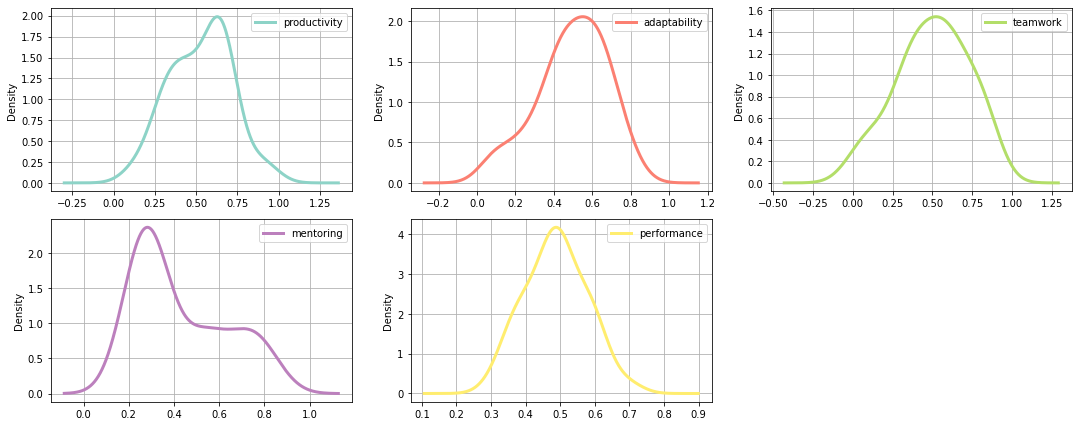

In [7]:
metrics.plot.kde(figsize = (15, 6), layout = (2, 3), subplots=True, cmap=cmap, sharey=False, sharex=False, grid=True, linewidth=3);
plt.tight_layout()
plt.savefig(images_folder + 'agg_distribution')

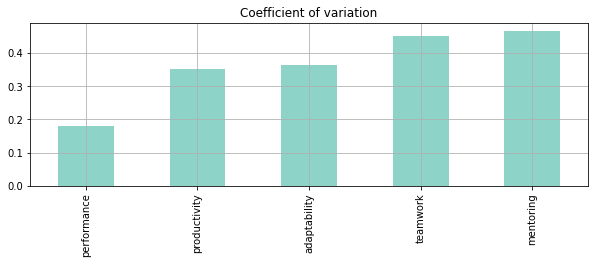

In [8]:
(describe.loc['std'] / describe.loc['mean']).sort_values().plot.bar(
    figsize=(10, 3), grid=True, title='Coefficient of variation', cmap=cmap);

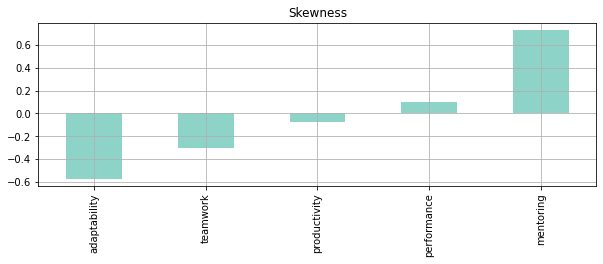

In [9]:
describe.loc['skew'].sort_values().plot.bar(
    figsize=(10, 3), grid=True, title='Skewness', cmap=cmap);

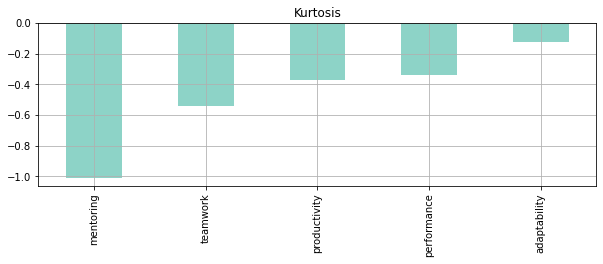

In [10]:
describe.loc['kurt'].sort_values().plot.bar(
    figsize=(10, 3), grid=True, title='Kurtosis', cmap=cmap);

# Redundancy

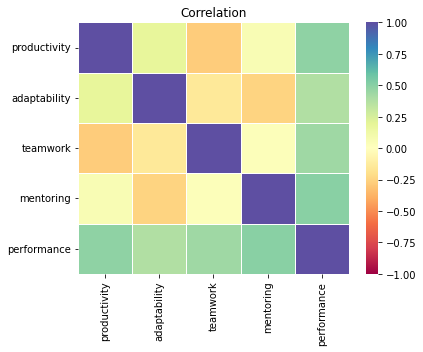

In [11]:
fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(1, 1, 1)
corr = metrics.corr()
sns.heatmap(corr, cmap="Spectral", vmin=-1, vmax=1, annot=False, linewidths=.5, ax=ax);
plt.title('Correlation');
plt.tight_layout()
plt.savefig(images_folder + 'agg_correlation')

# Stability

In [16]:
years = range(2019, 2023)
tags = list(users_and_metrics.keys())
yearly_metrics = {name: pd.concat([users_and_metrics[key][name] for key in tags], axis=1, keys=years) 
                  for name in metrics.columns}

In [17]:
n_iter = 100
yearly_random = {}
for i in range(n_iter):
    yearly_random[i] = {}
    for name in metrics.columns:
        yearly_random[i][name] = pd.DataFrame()
        for year in years:
            idx = yearly_metrics[name][year].dropna().index
            yearly_random[i][name][year] = yearly_metrics[name][year].loc[idx].sample(frac=1, replace=False).reset_index(drop=True)
            

In [18]:
yearly_std = [yearly_metrics[name].std(axis=1).rename(name) for name in metrics.columns]
yearly_std = pd.concat(yearly_std, axis=1)

In [19]:
yearly_random_std = {}
for i in range(n_iter):
    yearly_random_std[i] = [yearly_random[i][name].std(axis=1).rename(name) for name in metrics.columns]
    yearly_random_std[i] = pd.concat(yearly_random_std[i], axis=1)

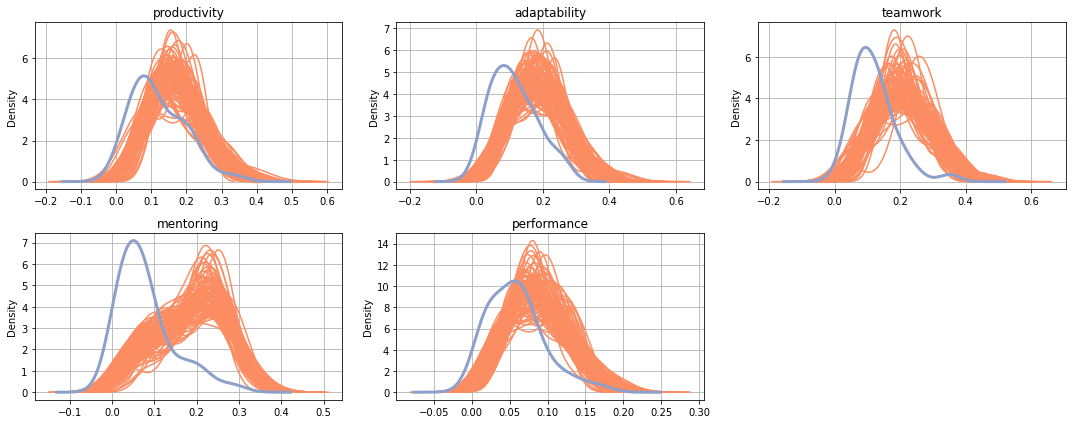

In [20]:
f = plt.figure(figsize=(15, 6))
for ii, name in enumerate(metrics.columns):
    ax = f.add_subplot(2, 3, ii + 1)
    for i in range(n_iter):
        yearly_random_std[i][name].plot.kde(color='#fc8d62')
    yearly_std[name].plot.kde(color='#8da0cb', linewidth=3, grid=True, title=name)
plt.tight_layout()
plt.savefig(images_folder + 'agg_stability')

# Reality

In [71]:
users, _ = read_users_file()
users['previous_experience'] = users['experience'] - users['service']
users = users.loc[metrics.index]

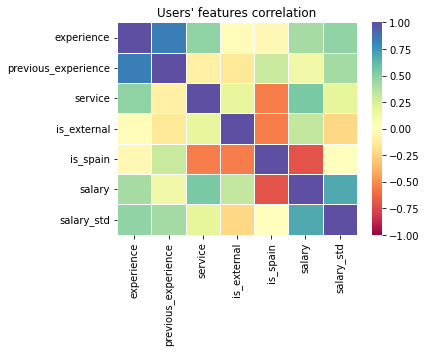

In [82]:
fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(1, 1, 1)
order = ['experience', 'previous_experience', 'service', 'is_external', 'is_spain', 'salary', 'salary_std']
to_plot = users[order].corr()
sns.heatmap(to_plot, cmap="Spectral", vmin=-1, vmax=1, annot=False, linewidths=.5, ax=ax); 
plt.title("Users' features correlation")
plt.tight_layout()
plt.savefig(images_folder + 'users_correlation')

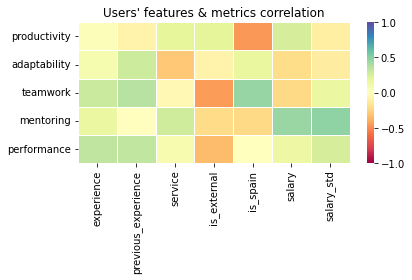

In [93]:
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(1, 1, 1)
to_plot = users[order].join(metrics).corr().loc[metrics.columns, order]
sns.heatmap(to_plot, cmap="Spectral", vmin=-1, vmax=1, annot=False, linewidths=.5, ax=ax); 
plt.title("Users' features & metrics correlation")
plt.tight_layout()
plt.savefig(images_folder + 'users_agg_correlation')

In [45]:
def linear_regression(x, y, significant=0.05):
    x = sm.add_constant(x)
    lr = sm.OLS(y, x)
    lr_fit = lr.fit()
    summary = lr_fit.summary2().tables[1][['Coef.', 'Std.Err.', 't', 'P>|t|']]
    summary['Significant'] = ['' if x > significant else '*' for x in summary['P>|t|'].values]
    return lr_fit.rsquared, summary

In [101]:
y = users['salary_std']
x = users[['previous_experience', 'service']]
x = x.join(users[['is_spain', 'is_external']])

In [102]:
linear_regression(x, y)

(0.290758196883835,
                         Coef.  Std.Err.         t     P>|t| Significant
 const                0.048987  0.587296  0.083411  0.933941            
 previous_experience  0.069707  0.021749  3.205038  0.002654           *
 service              0.042292  0.039740  1.064229  0.293607            
 is_spain            -0.520996  0.518325 -1.005152  0.320866            
 is_external         -1.335378  0.695533 -1.919935  0.062017            )

In [103]:
linear_regression(x.join(metrics['performance'], how='right'), y.loc[x.index])

(0.29104731677701023,
                         Coef.  Std.Err.         t     P>|t| Significant
 const                0.161418  1.071630  0.150628  0.881046            
 previous_experience  0.070872  0.023880  2.967815  0.005104           *
 service              0.042219  0.040242  1.049115  0.300583            
 is_spain            -0.541498  0.549423 -0.985575  0.330417            
 is_external         -1.378945  0.784417 -1.757924  0.086607            
 performance         -0.203785  1.615878 -0.126114  0.900290            )

In [104]:
linear_regression(x.join(metrics.drop(['performance'], axis=1), how='right'), y.loc[x.index])

(0.4588037539589118,
                         Coef.  Std.Err.         t     P>|t| Significant
 const                0.029333  0.999305  0.029353  0.976745            
 previous_experience  0.078371  0.022477  3.486716  0.001306           *
 service              0.023460  0.038644  0.607082  0.547607            
 is_spain            -0.224906  0.569963 -0.394596  0.695469            
 is_external         -0.856482  0.734929 -1.165394  0.251523            
 productivity        -0.578891  0.700929 -0.825892  0.414306            
 adaptability        -0.695865  0.740200 -0.940105  0.353429            
 teamwork            -0.554721  0.637534 -0.870104  0.390008            
 mentoring            1.641602  0.638343  2.571662  0.014396           *)

# Comparison

In [5]:
order = metrics.sort_values(by='performance').index
order = list(order)
split = [order[:11], order[11:-11], order[-11:]]
[', '.join(x) for x in split]

['alba, leticia, raquel, elena, judith, olga, alicia, charo, julia, rocio, paz',
 'ana, celia, veronica, adela, maira, patricia, alejandra, tania, teresa, carlota, sara, carolina, pilar, gema, fatima, beatriz, isabel, mar, irene, luisa, lucia, victoria, marta',
 'carmen, eva, nuria, marina, encarna, amaya, lidia, angela, francisca, stella, pura']

In [6]:
keys=['top_user', 'top_value', 'bottom_user', 'bottom_value']
top_bottom = [metrics.idxmax(), metrics.max(), metrics.idxmin(), metrics.min()]
top_bottom = pd.concat(top_bottom, axis=1, keys=keys)
top_bottom

,top_user,top_value,bottom_user,bottom_value
productivity,stella,0.945870,alba,0.115878
adaptability,irene,0.795468,judith,0.082365
teamwork,victoria,0.860213,paz,0.000000
mentoring,marina,0.909622,alba,0.191730
performance,pura,0.701076,alba,0.298415


In [7]:
top_bottom.to_clipboard()

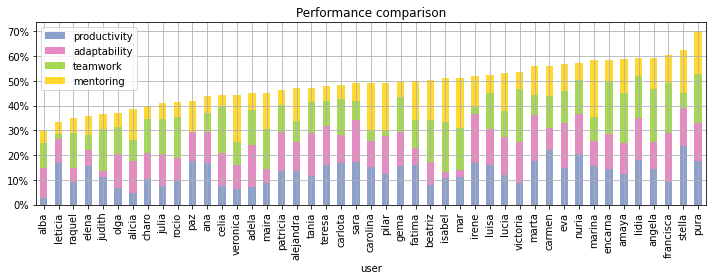

In [29]:
to_plot = (metrics.iloc[:, :4] * 0.25).loc[order]
ax = to_plot.plot.bar(stacked=True, figsize=(10, 4), grid=True, cmap=cmap_, title='Performance comparison');
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.tight_layout()
plt.savefig(images_folder + 'agg_comparison')

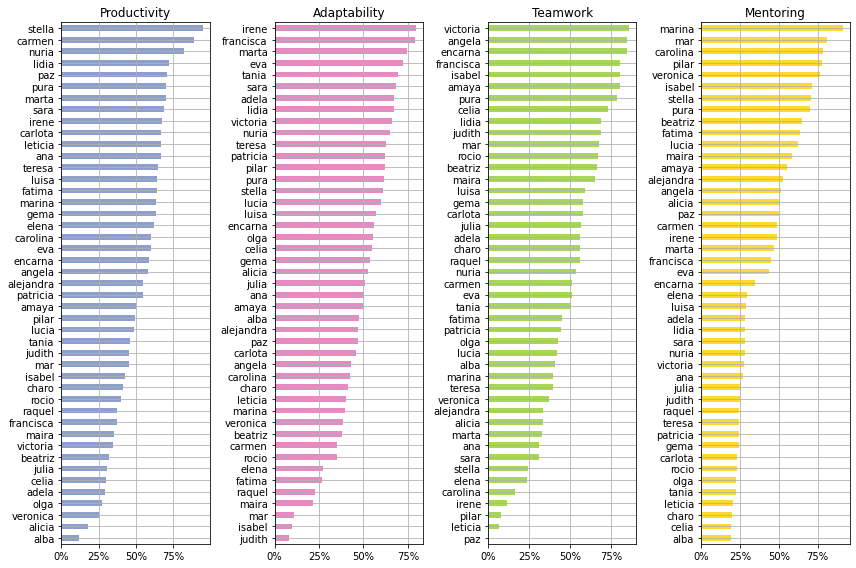

In [47]:
to_plot = metrics.iloc[:, :4].loc[order]
to_plot.index.name = ''

f = plt.figure(figsize=(12, 8))
for i, col in enumerate(to_plot.columns):
    ax = f.add_subplot(1, 4, i + 1)
    to_plot[col].sort_values().plot.barh(grid=True, legend=False, color=cmap_.colors[i], ax=ax, title=col.capitalize());
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.tight_layout()
plt.savefig(images_folder + 'agg_comparison_by_dimension')

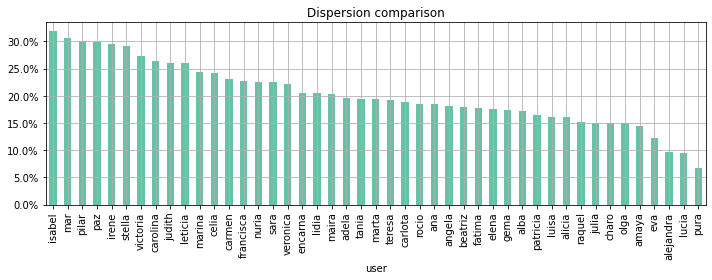

In [38]:
to_plot = metrics.iloc[:, :4].std(axis=1).sort_values(ascending=False)
ax = to_plot.plot.bar(figsize=(10, 4), grid=True, cmap=cmap_, title='Dispersion comparison', color='#66c2a5');
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.tight_layout()
plt.savefig(images_folder + 'agg_comparison_std')

# Clustering

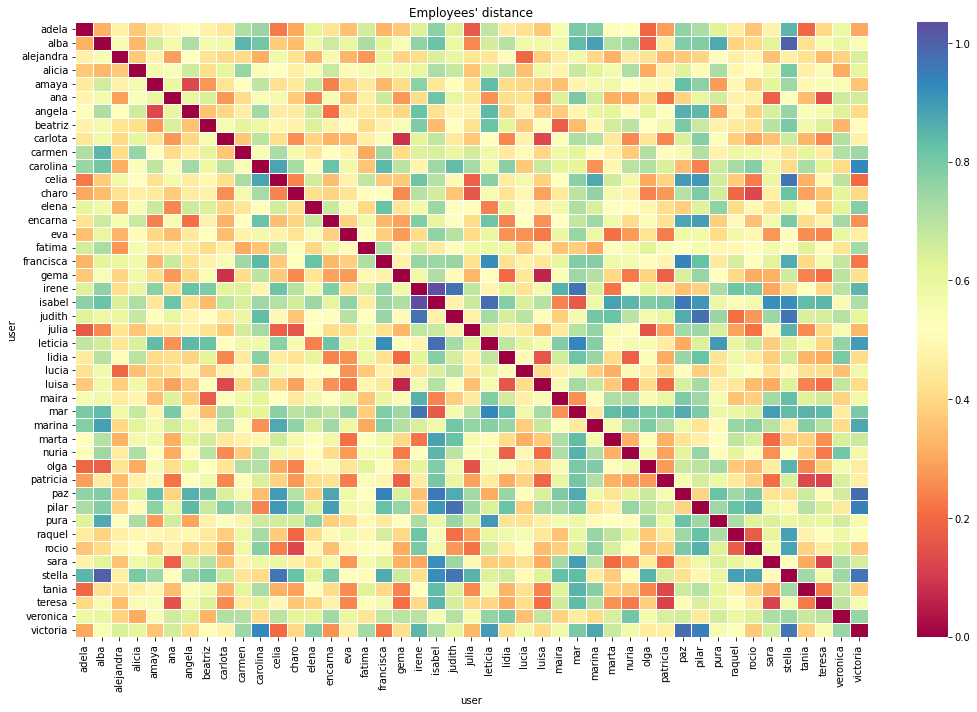

In [5]:
features = metrics.drop('performance', axis=1)
dist = DistanceMetric.get_metric('euclidean').pairwise(features)
dist = pd.DataFrame(dist, index=features.index, columns=features.index) 

fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(1, 1, 1)
sns.heatmap(dist, cmap="Spectral", annot=False, linewidths=.5, ax=ax); 
plt.title("Employees' distance");
plt.tight_layout()
plt.savefig(images_folder + 'clustering_distance')

In [50]:
metrics.loc[['isabel', 'irene']].to_clipboard()

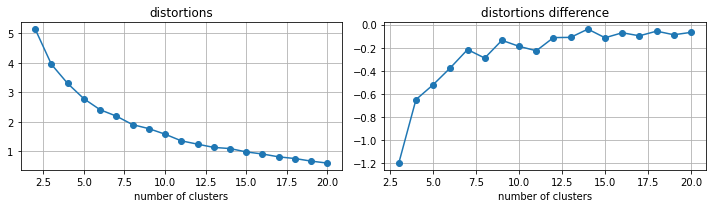

In [17]:
random_state = 17
n_clusters_range = range(2, 21)
distortions = {}
for n_clusters in n_clusters_range:
    km = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    clusters = km.fit_predict(features)
    distortions[n_clusters] = km.inertia_
    
f = plt.figure(figsize=(10, 3))
ax = f.add_subplot(1, 2, 1)
pd.Series(distortions).plot(title='distortions', marker='o', ax=ax, grid=True);
plt.xlabel('number of clusters')
ax = f.add_subplot(1, 2, 2)
pd.Series(distortions).diff().plot(title='distortions difference', marker='o', ax=ax, grid=True);
plt.xlabel('number of clusters')

plt.tight_layout()
plt.savefig(images_folder + 'clustering_n_clusters')

In [47]:
n_clusters = 4
km = KMeans(n_clusters=n_clusters, random_state=random_state)
kmeans_labels = km.fit_predict(features)
kmeans_labels = pd.Series(kmeans_labels, index=features.index)

cluster  0 ( 14 ):  ['ana', 'carlota', 'carmen', 'elena', 'eva', 'gema', 'leticia', 'lidia', 'luisa', 'marta', 'nuria', 'patricia', 'sara', 'teresa']
cluster  1 ( 10 ):  ['alejandra', 'carolina', 'fatima', 'irene', 'lucia', 'marina', 'paz', 'pilar', 'stella', 'veronica']
cluster  2 ( 12 ):  ['adela', 'alba', 'alicia', 'celia', 'charo', 'francisca', 'julia', 'olga', 'raquel', 'rocio', 'tania', 'victoria']
cluster  3 ( 9 ):  ['amaya', 'angela', 'beatriz', 'encarna', 'isabel', 'judith', 'maira', 'mar', 'pura']


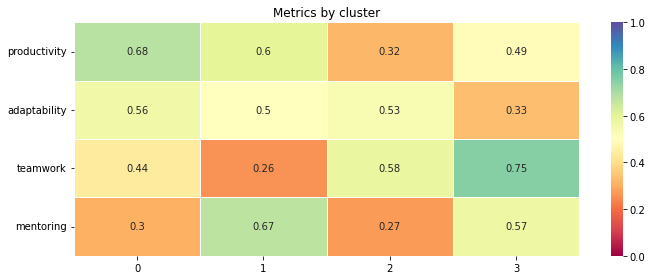

In [48]:
clusters_mean = []
for cluster in range(n_clusters):
    elements = kmeans_labels[kmeans_labels == cluster].index
    print('cluster ', cluster, '(', len(elements), '): ', list(elements))
    mean = features.loc[elements].mean().rename(cluster)
    clusters_mean.append(mean)
clusters_mean = pd.concat(clusters_mean, axis=1)

fig = plt.figure(figsize=(10, 4))
ax = plt.subplot(1, 1, 1)
sns.heatmap(clusters_mean, cmap="Spectral", annot=True, linewidths=.5, vmin=0, vmax=1, ax=ax); 
plt.title('Metrics by cluster');
plt.tight_layout()
plt.savefig(images_folder + 'clustering_heatmap')

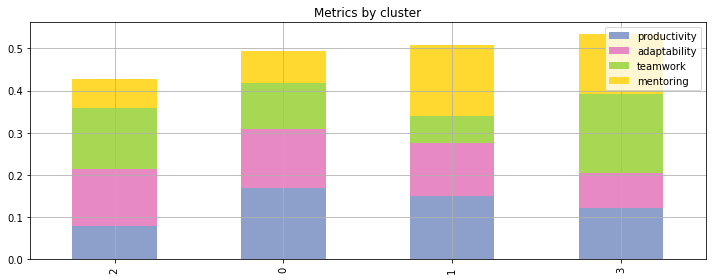

In [49]:
idx = clusters_mean.mean().sort_values().index
(clusters_mean[idx].T / features.shape[1]).plot.bar(stacked=True, cmap=cmap_, figsize=(10, 4), grid=True);
plt.title('Metrics by cluster');
plt.tight_layout()
plt.savefig(images_folder + 'clustering_comparison')

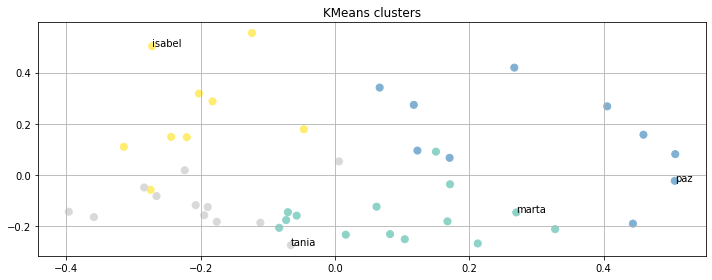

In [42]:
n_components = 2
estimator = PCA(n_components)
X_pca = estimator.fit_transform(features)
components_names = ['component_' + str(x) for x in range(n_components)]
pca_2d = pd.DataFrame(X_pca, columns=components_names, index=features.index)

fig = plt.figure(figsize=(10, 4))
ax = plt.subplot(1, 1, 1)

plt.scatter(pca_2d['component_0'], pca_2d['component_1'], c=kmeans_labels, s=50, cmap=cmap)
plt.title('KMeans clusters') 
plt.grid()

samples = [kmeans_labels[kmeans_labels == n].sample(1).index[0] for n in range(n_clusters)]
for user in samples:
    ax.text(pca_2d.loc[user].iloc[0], pca_2d.loc[user].iloc[1], user)
plt.tight_layout()
plt.savefig(images_folder + 'clustering_pca')

In [51]:
c2 = pd.DataFrame(estimator.components_, columns=features.columns)
c2

,productivity,adaptability,teamwork,mentoring
0,0.454996,0.170554,-0.813971,0.318342
1,-0.101089,-0.542848,0.150462,0.820036


In [52]:
c2.to_clipboard()

# ST

In [54]:
years = range(2019, 2023)
tags = list(users_and_metrics.keys())
yearly_metrics = {name: pd.concat([users_and_metrics[key][name] for key in tags], axis=1, keys=years) 
                  for name in metrics.columns}

In [86]:
yearly = pd.DataFrame(yearly_metrics['performance'])

In [87]:
ret = yearly.diff(axis=1)

In [88]:
out_ = users_calc[users_calc['max_date'] < '20221201'].index
in_ = users_calc[users_calc['min_date'] > '20190131'].index

In [77]:
out_ = [x for x in out_ if x in ret.index]
in_ = [x for x in in_ if x in ret.index]

<AxesSubplot:xlabel='user'>

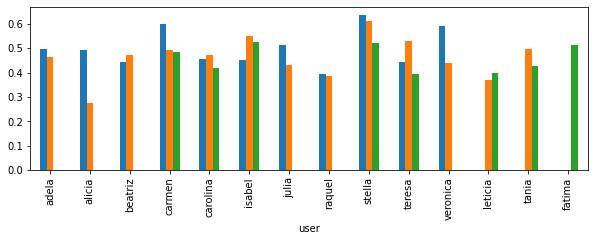

In [102]:
yearly[yearly[2022].isna()][[2019, 2020, 2021]].plot.bar(legend=False, figsize=(10, 3))

<AxesSubplot:xlabel='user'>

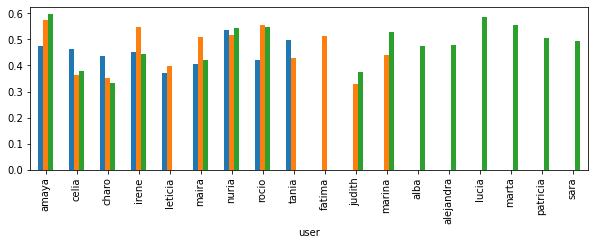

In [100]:
yearly[yearly[2019].isna()][[2020, 2021, 2022]].plot.bar(legend=False, figsize=(10, 3))

In [103]:
3300 * 40 / 8

16500.0

In [104]:
3300 * 80 / 8

33000.0

In [85]:
users_calc['max_date'].sort_values()

user
beatriz     2021-02-02
adela       2021-02-03
raquel      2021-02-03
veronica    2021-02-03
alicia      2021-02-03
carmen      2022-02-19
leticia     2022-02-23
isabel      2022-02-24
stella      2022-02-25
tania       2022-02-25
teresa      2022-02-25
paz         2022-02-28
fatima      2022-02-28
carolina    2022-02-28
marina      2022-09-30
francisca   2022-10-28
maira       2022-12-13
celia       2022-12-16
olga        2022-12-16
elena       2022-12-16
pilar       2022-12-22
luisa       2022-12-23
encarna     2022-12-23
pura        2022-12-23
ana         2022-12-23
nuria       2022-12-23
mar         2022-12-23
eva         2022-12-28
marta       2022-12-28
julia       2022-12-29
lucia       2022-12-29
lidia       2022-12-30
judith      2022-12-30
irene       2022-12-30
patricia    2022-12-30
gema        2022-12-30
charo       2022-12-30
carlota     2022-12-30
angela      2022-12-30
rocio       2022-12-30
sara        2022-12-30
amaya       2022-12-30
alejandra   2022-12-30
alba  

In [79]:
ret.loc[in_]

,2019,2020,2021,2022
user,,,,
adela,NaN,-0.030103,NaN,NaN
alba,NaN,NaN,NaN,NaN
alejandra,NaN,NaN,NaN,NaN
amaya,NaN,NaN,0.098172,0.022884
angela,NaN,0.136951,-0.061632,-0.020828
beatriz,NaN,0.029218,NaN,NaN
celia,NaN,NaN,-0.099072,0.018037
charo,NaN,NaN,-0.085555,-0.018950
encarna,NaN,-0.018125,-0.005153,0.084235


<AxesSubplot:xlabel='user'>

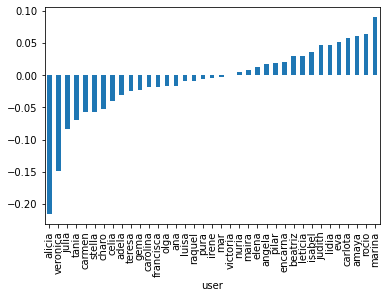

In [60]:
yearly_metrics['performance'].diff(axis=1).mean(axis=1).dropna().sort_values().plot.bar()

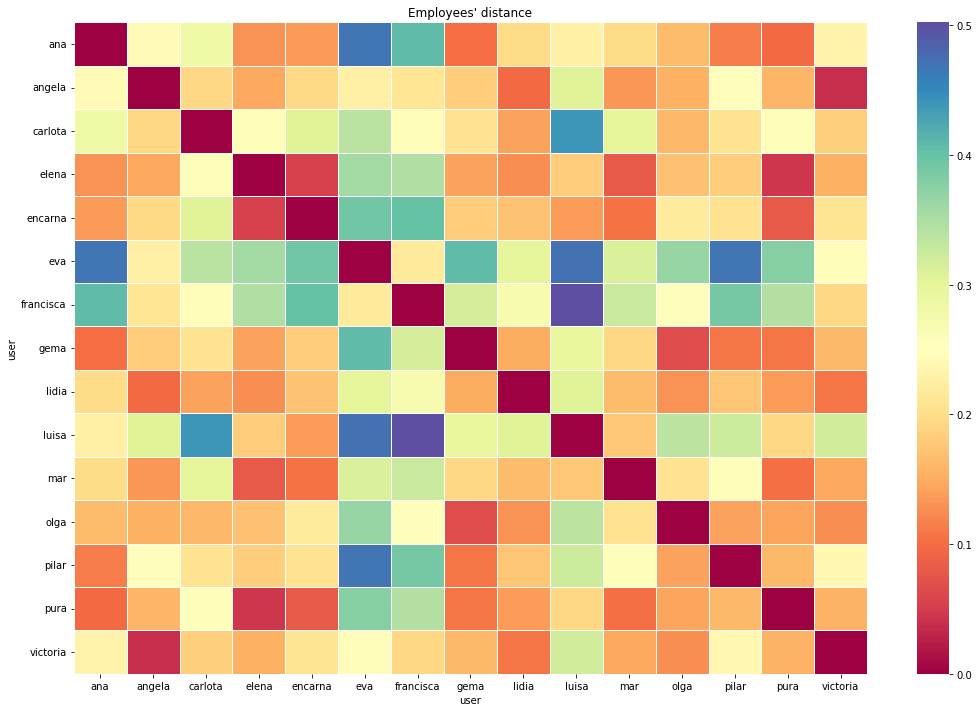

In [64]:
features = yearly_metrics['performance'].dropna().diff(axis=1).dropna(axis=1)
dist = DistanceMetric.get_metric('euclidean').pairwise(features)
dist = pd.DataFrame(dist, index=features.index, columns=features.index) 

fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(1, 1, 1)
sns.heatmap(dist, cmap="Spectral", annot=False, linewidths=.5, ax=ax); 
plt.title("Employees' distance");
plt.tight_layout()
plt.savefig(images_folder + 'clustering_distance')

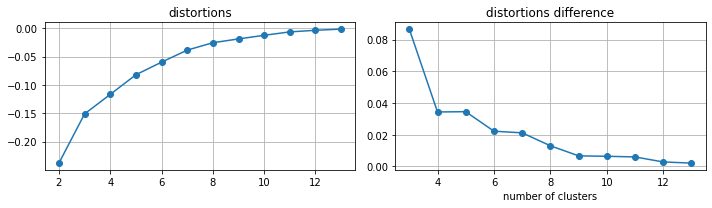

In [65]:
random_state = 17
n_clusters_range = range(2, 14)
distortions = {}
silhouettes = {}
for n_clusters in n_clusters_range:
    km = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    clusters = km.fit_predict(features)
    distortions[n_clusters] = km.score(features) # km.inertia_
    
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
pd.Series(distortions).plot(title='distortions', marker='o', ax=ax.flat[0]);
ax.flat[0].grid(True)
plt.xlabel('number of clusters')
pd.Series(distortions).diff().plot(title='distortions difference', marker='o', ax=ax.flat[1]);
plt.xlabel('number of clusters')
ax.flat[1].grid(True)    

plt.tight_layout()
plt.savefig(images_folder + 'clustering_n_clusters')

In [66]:
n_clusters = 4
km = KMeans(n_clusters=n_clusters, random_state=random_state)
kmeans_labels = km.fit_predict(features)
kmeans_labels = pd.Series(kmeans_labels, index=features.index)

cluster  0 ( 2 ):  ['eva', 'francisca']
cluster  1 ( 6 ):  ['ana', 'elena', 'encarna', 'luisa', 'mar', 'pura']
cluster  2 ( 3 ):  ['angela', 'lidia', 'victoria']
cluster  3 ( 4 ):  ['carlota', 'gema', 'olga', 'pilar']


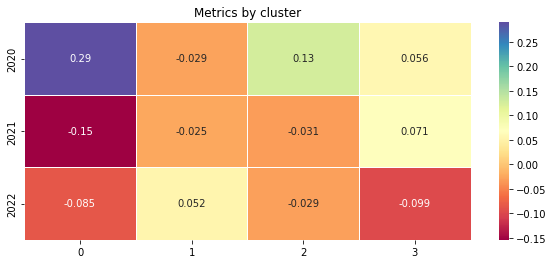

In [68]:
clusters_mean = []
for cluster in range(n_clusters):
    elements = kmeans_labels[kmeans_labels == cluster].index
    print('cluster ', cluster, '(', len(elements), '): ', list(elements))
    mean = features.loc[elements].mean().rename(cluster)
    clusters_mean.append(mean)
clusters_mean = pd.concat(clusters_mean, axis=1)

fig = plt.figure(figsize=(10, 4))
ax = plt.subplot(1, 1, 1)
sns.heatmap(clusters_mean, cmap="Spectral", annot=True, linewidths=.5, ax=ax); 
plt.title('Metrics by cluster');

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

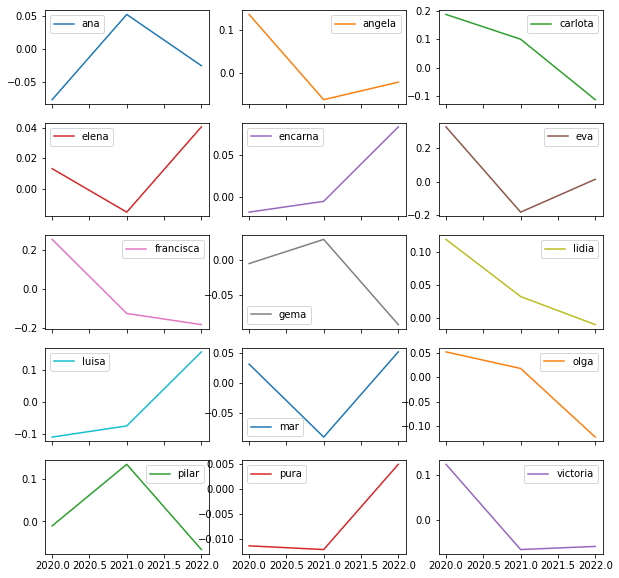

In [73]:
features.T.plot(subplots=True, layout=(5, 3), figsize=(10, 10));